# Simple Example of ParameterWithSetpoints
This notebook has an example of writing a simple driver with a parameter that has setpoints. This is most likely to be useful for instruments that return arrays of results. In this notebook we will show an example of this.

In [33]:
import numpy as np

In [34]:
from qcodes.dataset.plotting import plot_by_id
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.dataset.measurements import Measurement

In [35]:
from qcodes.dataset.database import initialise_database
from qcodes.dataset.experiment_container import new_experiment

In [36]:
from qcodes.instrument.parameter import ParameterWithSetpoints, GeneratedSetPoints

Here we define an dummy instrument that returns something like a frequency spectrum from a starting frequency give by `f_start` to a stop frequency given by `f_stop`
in `n_points` steps. 

The functionality of the ParameterWithSetpoints is implemented only by having a reference to it's setpoints which is consumed by the dataset context manager. To do this we only have to define the parameter for the setpoints and the spectrum and let the spectrum parameter know that the frequency axis is the setpoints axis of the spectrum.

In [5]:
class DummyArray(ParameterWithSetpoints):
    
    def get_raw(self):
        npoints = self.root_instrument.n_points()
        return np.random.rand(npoints)
    

class DummySpectrumAnalyzer(Instrument):
    
    def __init__(self, name, **kwargs):
        
        super().__init__(name, **kwargs)
            

        self.add_parameter('f_start',
                           initial_value=0,
                           unit='Hz',
                           label='f start',
                           vals=Numbers(0,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('f_stop',
                           unit='Hz',
                           label='f stop',
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('n_points',
                           unit='',
                           initial_value=10,
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter('freq_axis',
                           unit='Hz',
                           label='Freq Axis',
                           parameter_class=GeneratedSetPoints,
                           startparam=self.f_start,
                           stopparam=self.f_stop,
                           numpointsparam=self.n_points,
                           vals=Arrays(shape=(self.n_points,)))
                           
        self.add_parameter('spectrum',
                   unit='dBm',
                   setpoints=(self.freq_axis,),
                   label='Spectrum',
                   parameter_class=DummyArray,
                   vals=Arrays(shape=(self.n_points,)))
                

In [6]:
initialise_database()
new_experiment(name='tutorial_exp', sample_name="no sample")

tutorial_exp#no sample#67@C:\Users\jenielse/experiments.db
----------------------------------------------------------

In [7]:
a = DummySpectrumAnalyzer('foobar')

First we setup the limits of the spectrum

In [8]:
a.f_start(0)
a.f_stop(500)
a.n_points(501)

And we can grab the frequency axis

In [20]:
freq_axis = a.freq_axis()
len(freq_axis)

501

In [37]:
freq_axis[:10]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

As expected we get a result wit 501 points as we asked for an axis with 501 points. 

Above we have added a validator to the `freq_axis` parameter encoding the fact that this is an Array with `n_points`. Note that we do not have to supply the number of points as an integer but can supply a function that returns the valid number of points. This would normally be a QCoDeS parameter.

This will be checked if we validate the output.

In [19]:
a.freq_axis.validate(a.freq_axis.get())

Naturally we can also grap the spectrum.

In [21]:
spectrum = a.spectrum.get()
len(spectrum)

501

When we validate a ParameterWithSetpoints we automatically validate that the shape is consistent between the parameters and its setpoints. As well as validating the shape as above.

In [26]:
a.spectrum.validate(a.spectrum.get())

The consistent shapes can be validated explicitly.

In [27]:
a.spectrum.validate_consistent_shape()

We can inspect the setpoints of the spectrum.

In [23]:
a.spectrum.setpoints

(<qcodes.instrument.parameter.GeneratedSetPoints: freq_axis at 1914952775384>,)

Or even change them.

In [28]:
a.spectrum.setpoints = (a.freq_axis,)

## Measurement

We can also directly consume the parameter in a measurement. This implicitly calls get on the setpoint parameter(s) when the data is added to the datasaver.

In [31]:
meas = Measurement()
meas.register_parameter(a.spectrum)

with meas.run() as datasaver:
    datasaver.add_result((a.spectrum, a.spectrum.get(),))
    
    dataid = datasaver.run_id

Starting experimental run with id: 198


And plot it

([<matplotlib.axes._subplots.AxesSubplot at 0x1bddc6ef4e0>], [None])

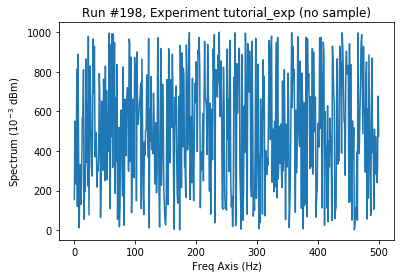

In [32]:
plot_by_id(dataid)